<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/master/assets/bernstein_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install ucimlrepo

In [2]:
%pip install --upgrade cvxpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.3.4
    Uninstalling cvxpy-1.3.4:
      Successfully uninstalled cvxpy-1.3.4


In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from ucimlrepo import fetch_ucirepo

# Load the data, and fix labels

## CDC Diabetes

In [15]:
# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

In [16]:
y = y.values.ravel()

In [17]:
print(X.describe().transpose()[['min', '25%', '50%', '75%', 'max']])

                       min   25%   50%   75%   max
HighBP                 0.0   0.0   0.0   1.0   1.0
HighChol               0.0   0.0   0.0   1.0   1.0
CholCheck              0.0   1.0   1.0   1.0   1.0
BMI                   12.0  24.0  27.0  31.0  98.0
Smoker                 0.0   0.0   0.0   1.0   1.0
Stroke                 0.0   0.0   0.0   0.0   1.0
HeartDiseaseorAttack   0.0   0.0   0.0   0.0   1.0
PhysActivity           0.0   1.0   1.0   1.0   1.0
Fruits                 0.0   0.0   1.0   1.0   1.0
Veggies                0.0   1.0   1.0   1.0   1.0
HvyAlcoholConsump      0.0   0.0   0.0   0.0   1.0
AnyHealthcare          0.0   1.0   1.0   1.0   1.0
NoDocbcCost            0.0   0.0   0.0   0.0   1.0
GenHlth                1.0   2.0   2.0   3.0   5.0
MentHlth               0.0   0.0   0.0   2.0  30.0
PhysHlth               0.0   0.0   0.0   3.0  30.0
DiffWalk               0.0   0.0   0.0   0.0   1.0
Sex                    0.0   0.0   0.0   1.0   1.0
Age                    1.0   6.

In [18]:
X[['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']].nunique()

BMI          84
GenHlth       5
MentHlth     31
PhysHlth     31
Age          13
Education     6
Income        8
dtype: int64

In [20]:
categorical_cols = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'DiffWalk', 'Sex', 'Education',
       'Income']
numerical_cols = ['Age', 'BMI', 'MentHlth', 'PhysHlth']

# Split the data

In [21]:
X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_remain, y_remain, test_size=0.15/0.85, random_state=43)

In [22]:
len(X_train), len(X_calib), len(X_test)

(177576, 38052, 38052)

# Expected calibration error

In [23]:
# implementation based on the code of calibration_curve in sklearn:
#   https://github.com/scikit-learn/scikit-learn/blob/872124551/sklearn/calibration.py#L927
def ece(y_true, y_prob, n_bins=10):
  bins = np.linspace(0.0, 1.0, n_bins + 1)
  binids = np.searchsorted(bins[1:-1], y_prob)

  bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
  bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
  bin_total = np.bincount(binids, minlength=len(bins))

  nonzero = bin_total != 0
  prob_true = bin_true[nonzero] / bin_total[nonzero]
  prob_pred = bin_sums[nonzero] / bin_total[nonzero]

  return np.sum(np.abs(prob_true - prob_pred) * bin_total[nonzero]) / np.sum(bin_total)

In [24]:
def estimator_ece(estimator, X, y):
  y_pred = estimator.predict_proba(X)[:, 1]
  return ece(y, y_pred)

# Build pipeline

In [25]:
pipeline = Pipeline([
    ('feature_transformer', ColumnTransformer(
        transformers=[
            ('categorical', OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=10), categorical_cols),
            ('numerical', MinMaxScaler(), numerical_cols)
        ]
    )),
    ('classifier', LinearSVC(class_weight='balanced', dual=False))
])

In [26]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_transformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=10),
                                                  ['HighBP', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'Stroke',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'AnyHealthcare',
                                                   'NoDocbcCost', 'GenHlth',
                                                   'DiffWalk', 'Sex',
                                                   'Education', 'Income']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['Age', 'BMI', 'MentHlth',
                                                   'PhysHlth'])])),
                ('classifier', LinearSVC(class_weight='balanced', dual=False))])

In [27]:
print(classification_report(y_test, pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     32840
           1       0.30      0.79      0.44      5212

    accuracy                           0.72     38052
   macro avg       0.63      0.75      0.63     38052
weighted avg       0.87      0.72      0.77     38052



In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, pipeline.decision_function(X_test))

0.8265313672280683

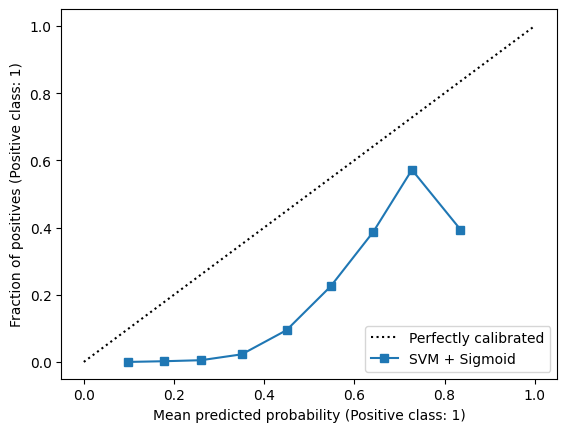

In [29]:
# naive calibration - just pass through the sigmoid
y_pred = pipeline.decision_function(X_test)
y_pred = 1 / (1 + np.exp(-y_pred))
CalibrationDisplay.from_predictions(y_test, y_pred, n_bins=10, name='SVM + Sigmoid')
plt.show()

In [30]:
print(f'ECE = {ece(y_test, y_pred)}')

ECE = 0.30732883382620496


In [31]:
from sklearn.metrics import (
    brier_score_loss,
    log_loss
)

brier_score_loss(y_test, y_pred), log_loss(y_test, y_pred)

(0.19391187428082382, 0.5748329800290517)

# Calibrate using Sigmoid / Isotonic calibrators

Use a calibrator of the form
$$
c(y) = \frac{1}{1 + \exp(-\alpha y + \beta)},
$$
where $\alpha, \beta$ are learned from the calibration set.

In [32]:
def estimator_errors(estimator, X_test, y_test):
  y_pred = estimator.predict_proba(X_test)[:, 1]
  return f'ECE = {ece(y_test, y_pred):.5f}, Brier = {brier_score_loss(y_test, y_pred):.5f}, LogLoss = {log_loss(y_test, y_pred):.5f}'

In [33]:
sigmoid_calib = CalibratedClassifierCV(pipeline, method='sigmoid', cv='prefit')
sigmoid_calib.fit(X_calib, y_calib)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('feature_transformer',
                                                  ColumnTransformer(transformers=[('categorical',
                                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                 min_frequency=10),
                                                                                   ['HighBP',
                                                                                    'HighChol',
                                                                                    'CholCheck',
                                                                                    'Smoker',
                                                                                    'Stroke',
                                                                                    'HeartDiseaseorAttack',
                                                                                    'PhysActivity',
                                                                                    'Fruits',
                                                                                    'Veggies',
                                                                                    'HvyAlcoholConsump',
                                                                                    'AnyHealthcare',
                                                                                    'NoDocbcCost',
                                                                                    'GenHlth',
                                                                                    'DiffWalk',
                                                                                    'Sex',
                                                                                    'Education',
                                                                                    'Income']),
                                                                                  ('numerical',
                                                                                   MinMaxScaler(),
                                                                                   ['Age',
                                                                                    'BMI',
                                                                                    'MentHlth',
                                                                                    'PhysHlth'])])),
                                                 ('classifier',
                                                  LinearSVC(class_weight='balanced',
                                                            dual=False))]))

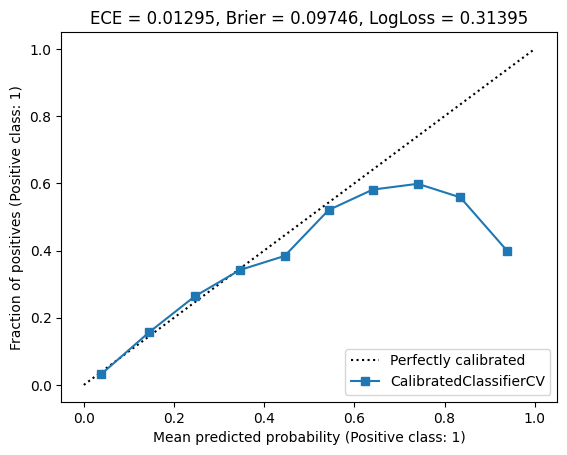

In [34]:
CalibrationDisplay.from_estimator(sigmoid_calib, X_test, y_test, n_bins=10)
plt.title(estimator_errors(sigmoid_calib, X_test, y_test))
plt.show()

Train a calibrator as a piecewise-constant function
$$
c(y) = \begin{cases}
y_0 & y \leq x_1 \\
y_1 & x_1 < y \leq x_2 \\
\vdots &  \\
y_{n-1} & x_{n-1} < y \leq x_n \\
y_n & y > x_n
\end{cases},
$$
where $y_0 < y_1 < \dots < y_n$, and $x_1, \dots, x_n$ are learned from the calibration set.

In [35]:
isotonic_calib = CalibratedClassifierCV(pipeline, method='isotonic', cv='prefit')
isotonic_calib.fit(X_calib, y_calib)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('feature_transformer',
                                                  ColumnTransformer(transformers=[('categorical',
                                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                 min_frequency=10),
                                                                                   ['HighBP',
                                                                                    'HighChol',
                                                                                    'CholCheck',
                                                                                    'Smoker',
                                                                                    'Stroke',
                                                                                    'HeartDiseaseorAttack',
                                                                                    'PhysActivity',
                                                                                    'Fruits',
                                                                                    'Veggies',
                                                                                    'HvyAlcoholConsump',
                                                                                    'AnyHealthcare',
                                                                                    'NoDocbcCost',
                                                                                    'GenHlth',
                                                                                    'DiffWalk',
                                                                                    'Sex',
                                                                                    'Education',
                                                                                    'Income']),
                                                                                  ('numerical',
                                                                                   MinMaxScaler(),
                                                                                   ['Age',
                                                                                    'BMI',
                                                                                    'MentHlth',
                                                                                    'PhysHlth'])])),
                                                 ('classifier',
                                                  LinearSVC(class_weight='balanced',
                                                            dual=False))]),
                       method='isotonic')

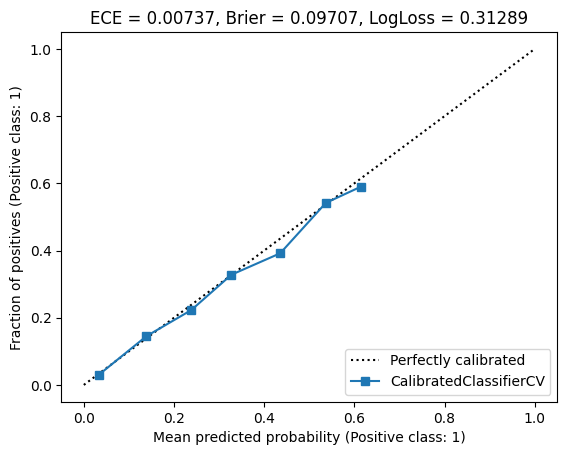

In [36]:
CalibrationDisplay.from_estimator(isotonic_calib, X_test, y_test, n_bins=10)
plt.title(estimator_errors(isotonic_calib, X_test, y_test))
plt.show()

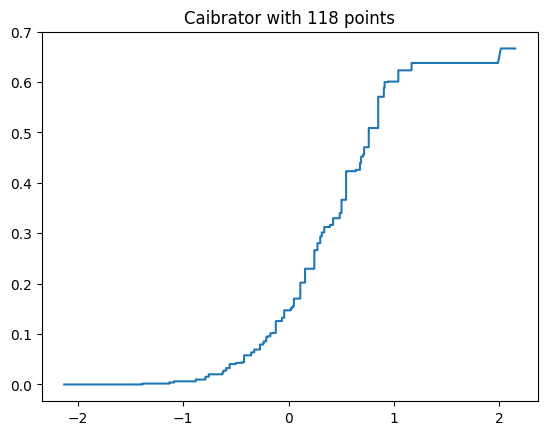

In [37]:
calibrator = isotonic_calib.calibrated_classifiers_[0].calibrators[0]
plt.plot(calibrator.f_.x, calibrator.f_.y)
plt.title(f'Caibrator with {len(calibrator.f_.x)} points')
plt.show()

# Bernstein calibrator

In [38]:
from sklearn.base import ClassifierMixin, MetaEstimatorMixin, BaseEstimator
import cvxpy as cp
from scipy.stats import binom

In [47]:
class BernsteinCalibrator(BaseEstimator, ClassifierMixin, MetaEstimatorMixin):
  def __init__(self, estimator=None, *, degree=20):
    self.estimator = estimator
    self.degree = degree

  def fit(self, X, y):
    pred = self._get_predictions(X)
    self.classes_ = self.estimator.classes_

    # compute min / max for scaling
    self.min_ = np.min(pred)
    self.max_ = np.max(pred)

    # compute Vandermonde matrix
    vander = self._bernvander(pred)

    # find Bernstein polynomial coefficients
    self.coef_ = self._compute_coef(vander, y)
    return self

  def _compute_coef(self, vander, y):
    coef = cp.Variable(self.degree + 1, bounds=[0, 1])
    objective = cp.norm(vander @ coef - y)
    constraints = [cp.diff(coef) >= 0]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve()

    return coef.value

  def predict_proba(self, X):
    pred = self._get_predictions(X)
    calibrated = self._calibrate_scores(pred).reshape(-1, 1)
    return np.concatenate([1 - calibrated, calibrated], axis=1)

  def _calibrate_scores(self, pred):
    vander = self._bernvander(pred)
    return np.clip(vander @ self.coef_, 0, 1)

  def _bernvander(self, pred):
    scaled = (pred - self.min_) / (self.max_ - self.min_)
    scaled = np.clip(scaled, 0, 1)

    basis_idx = np.arange(1 + self.degree)
    return binom.pmf(basis_idx, self.degree, scaled[:, None])

  def _get_predictions(self, X):
    estimator = self.estimator
    if estimator is None:
      estimator = LinearSVC(random_state=0, dual="auto")
    if hasattr(estimator, 'predict_proba'):
      pred = estimator.predict_proba(X)
      return pred[:, 1]
    elif hasattr(estimator, 'decision_function'):
      return estimator.decision_function(X)
    else:
      raise RuntimeError('Estimator must have either predict_proba or decison_function method')

In [48]:
bernstein_calib = BernsteinCalibrator(pipeline)
bernstein_calib.fit(X_calib, y_calib)

BernsteinCalibrator(estimator=Pipeline(steps=[('feature_transformer',
                                               ColumnTransformer(transformers=[('categorical',
                                                                                OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                              min_frequency=10),
                                                                                ['HighBP',
                                                                                 'HighChol',
                                                                                 'CholCheck',
                                                                                 'Smoker',
                                                                                 'Stroke',
                                                                                 'HeartDiseaseorAttack',
                                                                                 'PhysActivity',
                                                                                 'Fruits',
                                                                                 'Veggies',
                                                                                 'HvyAlcoholConsump',
                                                                                 'AnyHealthcare',
                                                                                 'NoDocbcCost',
                                                                                 'GenHlth',
                                                                                 'DiffWalk',
                                                                                 'Sex',
                                                                                 'Education',
                                                                                 'Income']),
                                                                               ('numerical',
                                                                                MinMaxScaler(),
                                                                                ['Age',
                                                                                 'BMI',
                                                                                 'MentHlth',
                                                                                 'PhysHlth'])])),
                                              ('classifier',
                                               LinearSVC(class_weight='balanced',
                                                         dual=False))]))

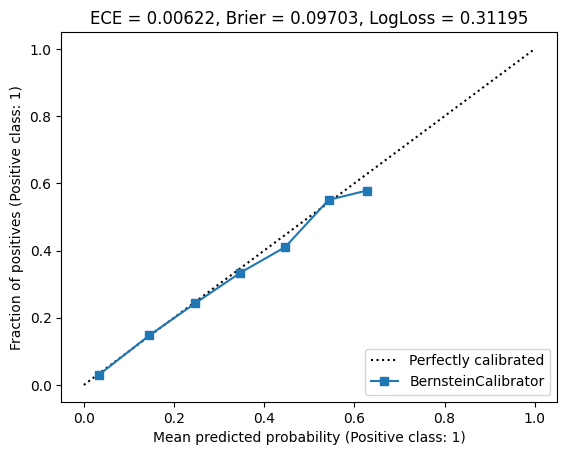

In [50]:
CalibrationDisplay.from_estimator(bernstein_calib, X_test, y_test, n_bins=10)
plt.title(estimator_errors(bernstein_calib, X_test, y_test))
plt.show()

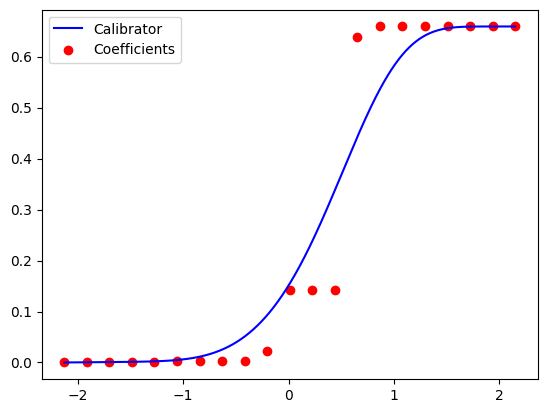

In [62]:
xs = np.linspace(bernstein_calib.min_, bernstein_calib.max_, 1000)
ys = bernstein_calib._calibrate_scores(xs)
plt.plot(xs, ys, label='Calibrator', color='blue')

ctrl_xs = np.linspace(bernstein_calib.min_, bernstein_calib.max_, bernstein_calib.degree + 1)
ctrl_ys = bernstein_calib.coef_
plt.scatter(ctrl_xs, ctrl_ys, label='Coefficients', color='red')

plt.legend()
plt.show()


In [51]:
bernstein_calib_lowdeg = BernsteinCalibrator(pipeline, degree=10)
bernstein_calib_lowdeg.fit(X_calib, y_calib)

BernsteinCalibrator(degree=10,
                    estimator=Pipeline(steps=[('feature_transformer',
                                               ColumnTransformer(transformers=[('categorical',
                                                                                OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                              min_frequency=10),
                                                                                ['HighBP',
                                                                                 'HighChol',
                                                                                 'CholCheck',
                                                                                 'Smoker',
                                                                                 'Stroke',
                                                                                 'HeartDiseaseorAttack',
                                                                                 'PhysActivity',
                                                                                 'Fruits',
                                                                                 'Veggies',
                                                                                 'HvyAlcoholConsump',
                                                                                 'AnyHealthcare',
                                                                                 'NoDocbcCost',
                                                                                 'GenHlth',
                                                                                 'DiffWalk',
                                                                                 'Sex',
                                                                                 'Education',
                                                                                 'Income']),
                                                                               ('numerical',
                                                                                MinMaxScaler(),
                                                                                ['Age',
                                                                                 'BMI',
                                                                                 'MentHlth',
                                                                                 'PhysHlth'])])),
                                              ('classifier',
                                               LinearSVC(class_weight='balanced',
                                                         dual=False))]))

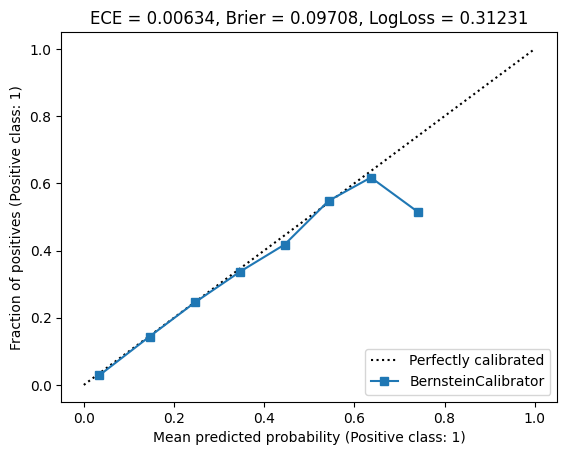

In [52]:
CalibrationDisplay.from_estimator(bernstein_calib_lowdeg, X_test, y_test, n_bins=10)
plt.title(estimator_errors(bernstein_calib_lowdeg, X_test, y_test))
plt.show()

# Bernstein logistic calibrator

In [53]:
class BernsteinSigmoidCalibrator(BernsteinCalibrator):
  def _compute_coef(self, vander, y):
    coef = cp.Variable(self.degree + 1, bounds=[-15, 15])
    scores = vander @ coef
    objective = cp.sum(cp.logistic(scores) - cp.multiply(y, scores))
    constraints = [cp.diff(coef) >= 0]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve()

    return coef.value

  def _calibrate_scores(self, pred):
    vander = self._bernvander(pred)
    return self._sigmoid(vander @ self.coef_)

  @staticmethod
  def _sigmoid(scores):
    return np.piecewise(
        scores,
        [scores > 0],
        [lambda z: 1 / (1 + np.exp(-z)), lambda z: np.exp(z) / (1 + np.exp(z))]
    )

In [54]:
bernstein_sigmoid_calib = BernsteinSigmoidCalibrator(pipeline, degree=10)
bernstein_sigmoid_calib.fit(X_calib, y_calib)

BernsteinSigmoidCalibrator(degree=10,
                           estimator=Pipeline(steps=[('feature_transformer',
                                                      ColumnTransformer(transformers=[('categorical',
                                                                                       OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                     min_frequency=10),
                                                                                       ['HighBP',
                                                                                        'HighChol',
                                                                                        'CholCheck',
                                                                                        'Smoker',
                                                                                        'Stroke',
                                                                                        'HeartDiseaseorAttack',
                                                                                        'PhysActivity',
                                                                                        'Fruits',
                                                                                        'Veggies',
                                                                                        'HvyAlcoholConsump',
                                                                                        'AnyHealthcare',
                                                                                        'NoDocbcCost',
                                                                                        'GenHlth',
                                                                                        'DiffWalk',
                                                                                        'Sex',
                                                                                        'Education',
                                                                                        'Income']),
                                                                                      ('numerical',
                                                                                       MinMaxScaler(),
                                                                                       ['Age',
                                                                                        'BMI',
                                                                                        'MentHlth',
                                                                                        'PhysHlth'])])),
                                                     ('classifier',
                                                      LinearSVC(class_weight='balanced',
                                                                dual=False))]))

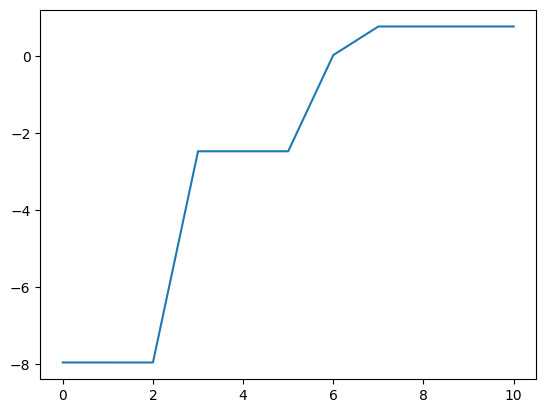

In [55]:
plt.plot(bernstein_sigmoid_calib.coef_)

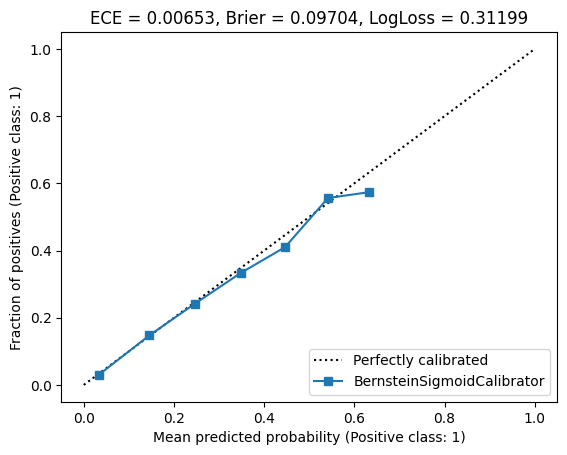

In [56]:
CalibrationDisplay.from_estimator(bernstein_sigmoid_calib, X_test, y_test, n_bins=10)
plt.title(estimator_errors(bernstein_sigmoid_calib, X_test, y_test))
plt.show()

# Summary of all calibration curves

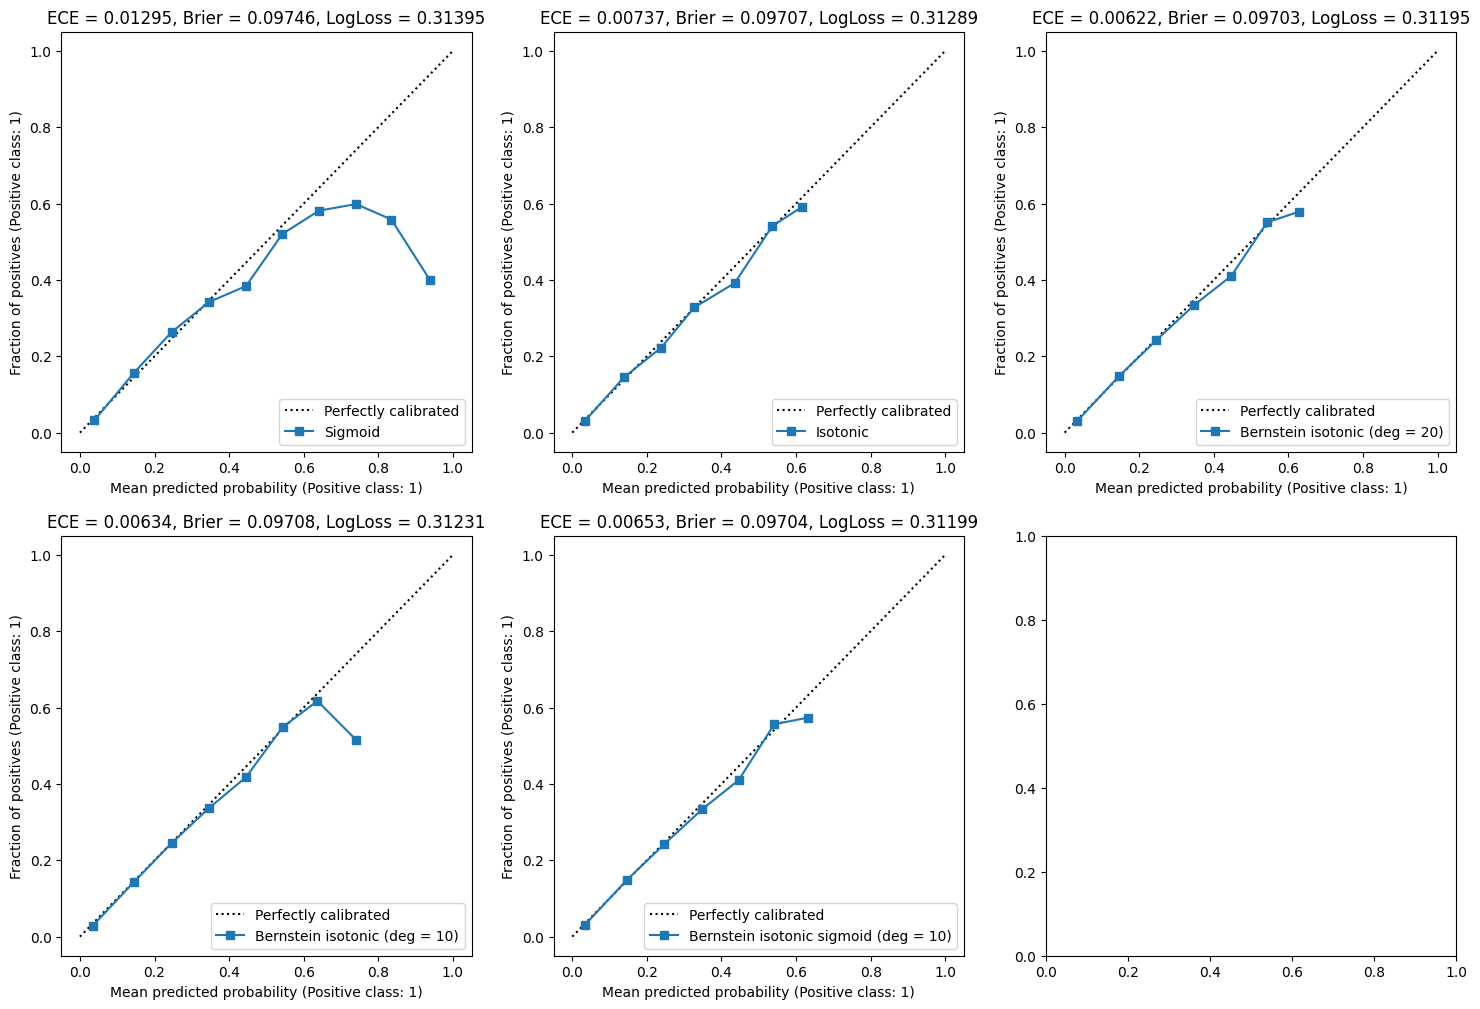

In [58]:
calibrators = [
    (sigmoid_calib, 'Sigmoid'),
    (isotonic_calib, 'Isotonic'),
    (bernstein_calib, f'Bernstein isotonic (deg = {bernstein_calib.degree})'),
    (bernstein_calib_lowdeg, f'Bernstein isotonic (deg = {bernstein_calib_lowdeg.degree})'),
    (bernstein_sigmoid_calib, f'Bernstein isotonic sigmoid (deg = {bernstein_sigmoid_calib.degree})')
]

ncols = math.ceil(math.sqrt(len(calibrators)))
nrows = math.ceil(len(calibrators) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6))
def plot_curve_ece(estimator, ax, name):
  CalibrationDisplay.from_estimator(estimator, X_test, y_test, n_bins=10, ax=ax, name=name)
  ax.set_title(estimator_errors(estimator, X_test, y_test))


for i, (calib, name) in enumerate(calibrators):
  ax = axs[i // ncols, i % ncols]
  plot_curve_ece(calib, ax, name)

plt.show()

In [63]:
for calib, name in calibrators:
  print(name + ", " + estimator_errors(calib, X_test, y_test))

Sigmoid, ECE = 0.01295, Brier = 0.09746, LogLoss = 0.31395
Isotonic, ECE = 0.00737, Brier = 0.09707, LogLoss = 0.31289
Bernstein isotonic (deg = 20), ECE = 0.00622, Brier = 0.09703, LogLoss = 0.31195
Bernstein isotonic (deg = 10), ECE = 0.00634, Brier = 0.09708, LogLoss = 0.31231
Bernstein isotonic sigmoid (deg = 10), ECE = 0.00653, Brier = 0.09704, LogLoss = 0.31199
